# Unified Model Comparison

**Objective**: Compare all models (Temporal GCN, Static GCN, MLP + Graph Features, Baselines) across observation windows K.

**Data source**: Pre-computed multi-seed results from all experiment notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Load All Results

In [2]:
# Define result directories for each model
results_dirs = {
    'Temporal GCN': Path('../../results/evolve_gcn_multi_seed'),
    'Static GCN': Path('../../results/static_gcn_multi_seed'),
    'MLP + Graph Features': Path('../../results/graph_features_baseline_multi_seed'),
    'Logistic Regression': Path('../../results/baselines_multi_seed/logistic_regression'),
    'Random Forest': Path('../../results/baselines_multi_seed/random_forest'),
    'XGBoost': Path('../../results/baselines_multi_seed/xgboost')
}

# Load all results
all_models_results = {}

for model_name, result_dir in results_dirs.items():
    csv_path = result_dir / 'all_seeds_all_metrics.csv'
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df['model'] = model_name
        all_models_results[model_name] = df
        print(f"✓ Loaded {model_name}: {len(df)} rows")
    else:
        print(f"✗ Missing: {csv_path}")

# Combine all results
combined_df = pd.concat(all_models_results.values(), ignore_index=True)
print(f"\nTotal combined results: {len(combined_df)} rows")
print(f"Models: {combined_df['model'].unique()}")
print(f"K values: {sorted(combined_df['K'].unique())}")
print(f"Splits: {combined_df['split'].unique()}")

✓ Loaded Temporal GCN: 36 rows
✓ Loaded Static GCN: 36 rows
✗ Missing: ../../results/graph_features_baseline_multi_seed/all_seeds_all_metrics.csv
✗ Missing: ../../results/baselines_multi_seed/logistic_regression/all_seeds_all_metrics.csv
✗ Missing: ../../results/baselines_multi_seed/random_forest/all_seeds_all_metrics.csv
✗ Missing: ../../results/baselines_multi_seed/xgboost/all_seeds_all_metrics.csv

Total combined results: 72 rows
Models: ['Temporal GCN' 'Static GCN']
K values: [np.int64(1), np.int64(3), np.int64(5), np.int64(7)]
Splits: ['train' 'val' 'test']


## Compute Summary Statistics

In [3]:
# Filter test set only
test_df = combined_df[combined_df['split'] == 'test'].copy()

# Compute mean and std for each model/K combination
summary_stats = test_df.groupby(['model', 'K']).agg({
    'f1': ['mean', 'std'],
    'auc': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'accuracy': ['mean', 'std']
}).reset_index()

# Flatten column names
summary_stats.columns = ['_'.join(col).strip('_') for col in summary_stats.columns.values]

print("Summary statistics computed:")
print(summary_stats.head(10))

Summary statistics computed:
          model  K   f1_mean    f1_std  auc_mean   auc_std  precision_mean  \
0    Static GCN  1  0.168285  0.156002  0.508565  0.153717        0.133388   
1    Static GCN  3  0.123438  0.053613  0.602847  0.013123        0.459836   
2    Static GCN  5  0.179157  0.026947  0.547933  0.041807        0.185118   
3    Static GCN  7  0.165910  0.058817  0.589663  0.050263        0.151183   
4  Temporal GCN  1  0.311817  0.064746  0.752537  0.043471        0.229238   
5  Temporal GCN  3  0.338291  0.042284  0.732362  0.062170        0.263433   
6  Temporal GCN  5  0.301266  0.018545  0.679394  0.015403        0.230596   
7  Temporal GCN  7  0.332291  0.034218  0.781991  0.002589        0.233152   

   precision_std  recall_mean  recall_std  accuracy_mean  accuracy_std  
0       0.152980     0.476281    0.476649       0.510113      0.403331  
1       0.354101     0.259279    0.361177       0.787568      0.230838  
2       0.093520     0.444414    0.480482       0

## Visualization 1: F1 Score Comparison (All Models)

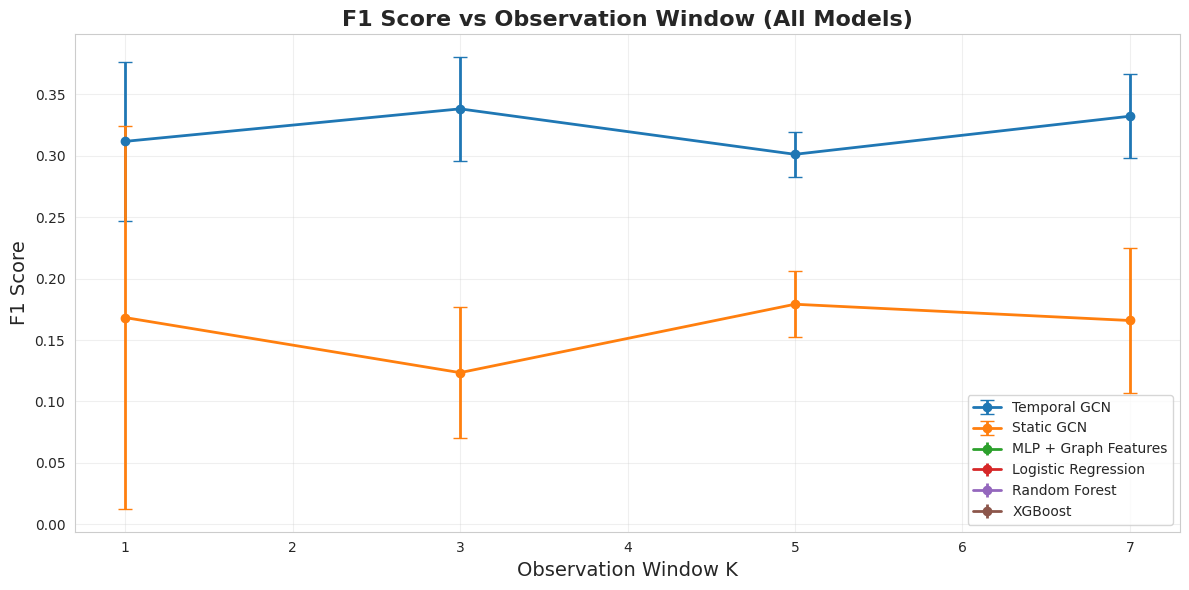

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

for model_name in results_dirs.keys():
    model_data = summary_stats[summary_stats['model'] == model_name]
    ax.errorbar(
        model_data['K'],
        model_data['f1_mean'],
        yerr=model_data['f1_std'],
        marker='o',
        linewidth=2,
        capsize=5,
        label=model_name
    )

ax.set_xlabel('Observation Window K', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_title('F1 Score vs Observation Window (All Models)', fontsize=16, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization 2: AUC Comparison (All Models)

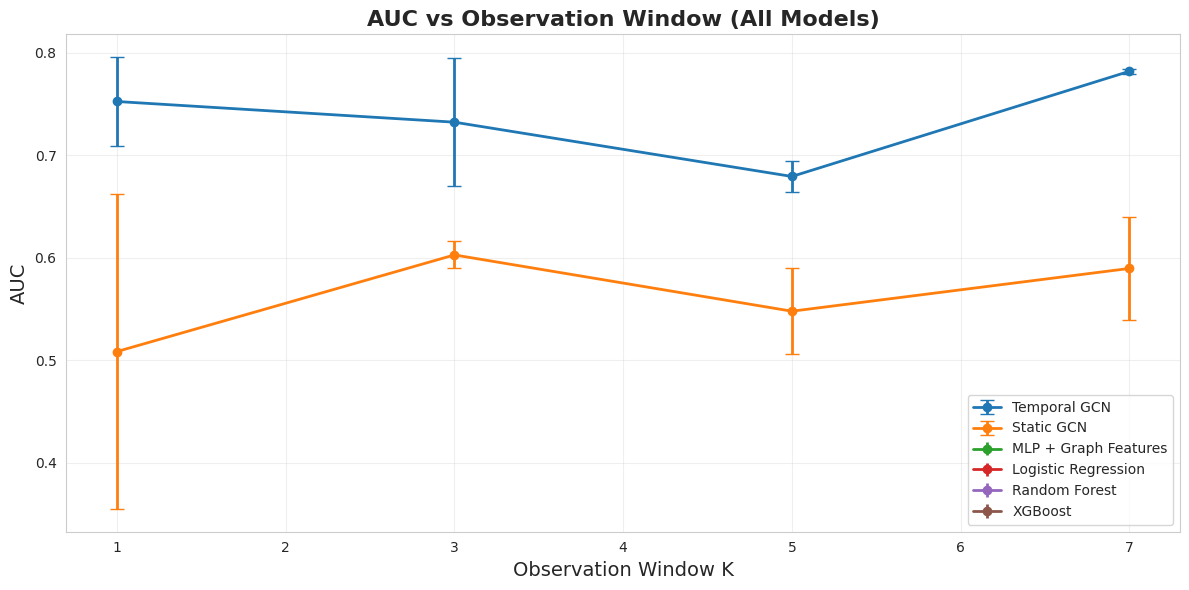

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

for model_name in results_dirs.keys():
    model_data = summary_stats[summary_stats['model'] == model_name]
    ax.errorbar(
        model_data['K'],
        model_data['auc_mean'],
        yerr=model_data['auc_std'],
        marker='o',
        linewidth=2,
        capsize=5,
        label=model_name
    )

ax.set_xlabel('Observation Window K', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('AUC vs Observation Window (All Models)', fontsize=16, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization 3: Heatmap (F1 Scores)

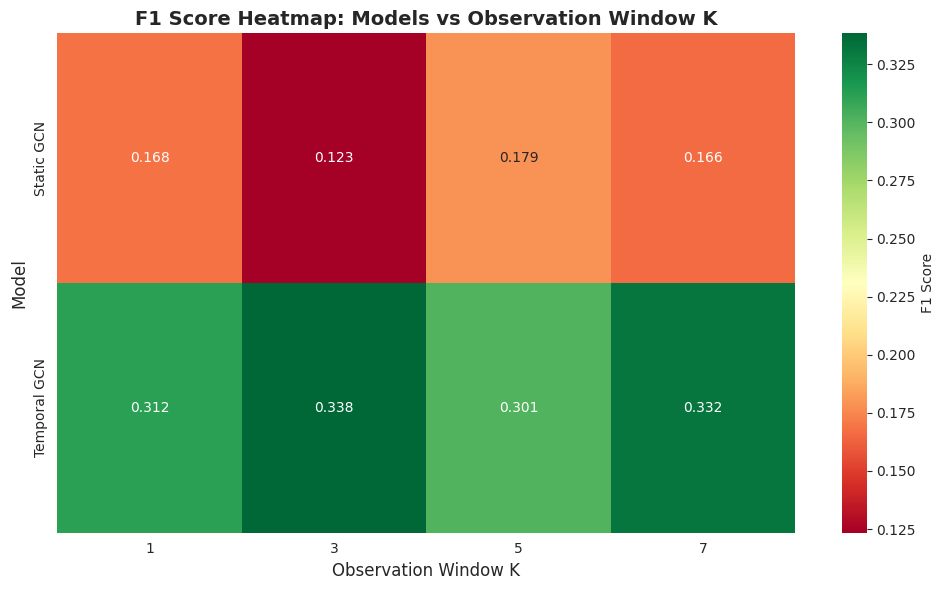

In [6]:
# Create pivot table for heatmap
f1_pivot = summary_stats.pivot(index='model', columns='K', values='f1_mean')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'F1 Score'})
ax.set_title('F1 Score Heatmap: Models vs Observation Window K', fontsize=14, fontweight='bold')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()

## Visualization 4: Best Model per K

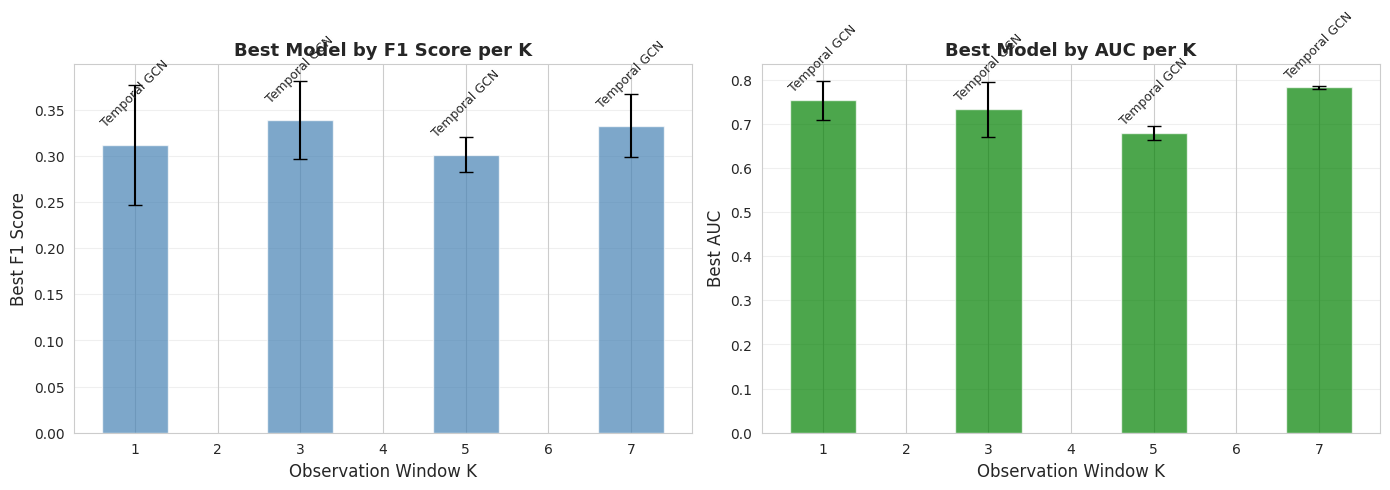

In [7]:
# Find best model for each K
best_per_k_f1 = summary_stats.loc[summary_stats.groupby('K')['f1_mean'].idxmax()]
best_per_k_auc = summary_stats.loc[summary_stats.groupby('K')['auc_mean'].idxmax()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Best F1
ax = axes[0]
ax.bar(best_per_k_f1['K'], best_per_k_f1['f1_mean'], color='steelblue', alpha=0.7)
ax.errorbar(best_per_k_f1['K'], best_per_k_f1['f1_mean'], 
            yerr=best_per_k_f1['f1_std'], fmt='none', color='black', capsize=5)
for i, (k, model) in enumerate(zip(best_per_k_f1['K'], best_per_k_f1['model'])):
    ax.text(k, best_per_k_f1['f1_mean'].iloc[i] + 0.02, model, 
            ha='center', fontsize=9, rotation=45)
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('Best F1 Score', fontsize=12)
ax.set_title('Best Model by F1 Score per K', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Best AUC
ax = axes[1]
ax.bar(best_per_k_auc['K'], best_per_k_auc['auc_mean'], color='green', alpha=0.7)
ax.errorbar(best_per_k_auc['K'], best_per_k_auc['auc_mean'], 
            yerr=best_per_k_auc['auc_std'], fmt='none', color='black', capsize=5)
for i, (k, model) in enumerate(zip(best_per_k_auc['K'], best_per_k_auc['model'])):
    ax.text(k, best_per_k_auc['auc_mean'].iloc[i] + 0.02, model, 
            ha='center', fontsize=9, rotation=45)
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('Best AUC', fontsize=12)
ax.set_title('Best Model by AUC per K', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Visualization 5: Variance Analysis (Model Stability)

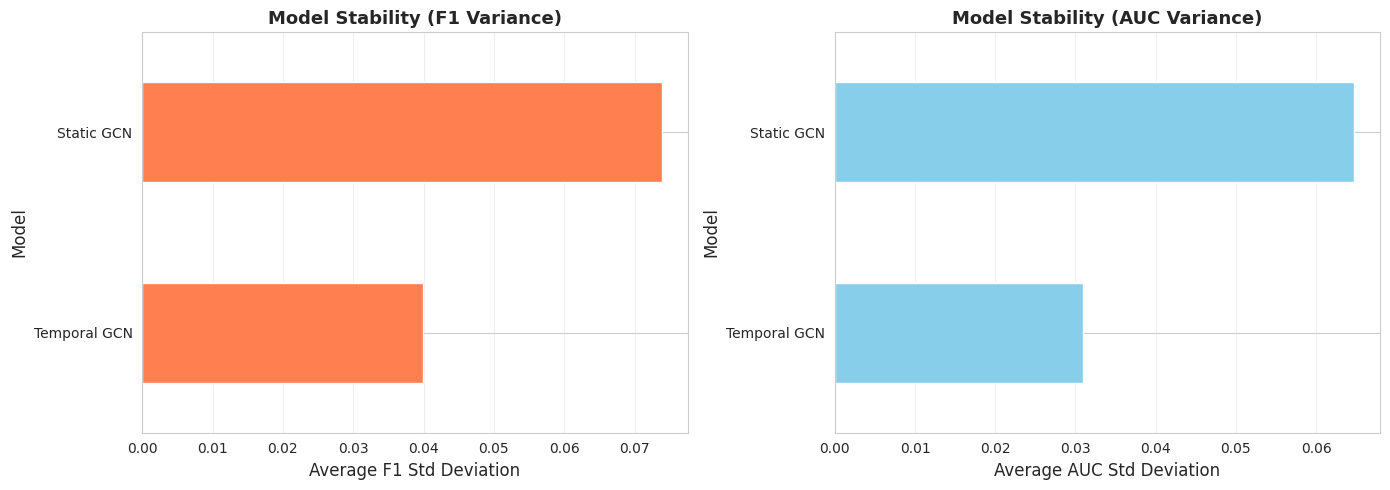


Model Stability Ranking (lower std = more stable):
                f1_std   auc_std
model                           
Temporal GCN  0.039948  0.030908
Static GCN    0.073845  0.064728


In [8]:
# Average std across all K values for each model
stability = summary_stats.groupby('model').agg({
    'f1_std': 'mean',
    'auc_std': 'mean'
}).sort_values('f1_std')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Stability
ax = axes[0]
stability['f1_std'].plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel('Average F1 Std Deviation', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Model Stability (F1 Variance)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# AUC Stability
ax = axes[1]
stability['auc_std'].plot(kind='barh', ax=ax, color='skyblue')
ax.set_xlabel('Average AUC Std Deviation', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Model Stability (AUC Variance)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nModel Stability Ranking (lower std = more stable):")
print(stability)

## Comparison Tables

In [9]:
# Create formatted comparison table
comparison_table = summary_stats.copy()
comparison_table['F1'] = comparison_table.apply(
    lambda x: f"{x['f1_mean']:.3f} ± {x['f1_std']:.3f}", axis=1
)
comparison_table['AUC'] = comparison_table.apply(
    lambda x: f"{x['auc_mean']:.3f} ± {x['auc_std']:.3f}", axis=1
)
comparison_table['Precision'] = comparison_table.apply(
    lambda x: f"{x['precision_mean']:.3f} ± {x['precision_std']:.3f}", axis=1
)
comparison_table['Recall'] = comparison_table.apply(
    lambda x: f"{x['recall_mean']:.3f} ± {x['recall_std']:.3f}", axis=1
)

display_table = comparison_table[['model', 'K', 'F1', 'AUC', 'Precision', 'Recall']]

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (Test Set, Mean ± Std)")
print("="*80)
print(display_table.to_string(index=False))

# Best performers
print("\n" + "="*80)
print("BEST PERFORMERS")
print("="*80)
print("\nBest F1 Score per K:")
print(best_per_k_f1[['K', 'model', 'f1_mean', 'f1_std']].to_string(index=False))
print("\nBest AUC per K:")
print(best_per_k_auc[['K', 'model', 'auc_mean', 'auc_std']].to_string(index=False))


COMPREHENSIVE MODEL COMPARISON (Test Set, Mean ± Std)
       model  K            F1           AUC     Precision        Recall
  Static GCN  1 0.168 ± 0.156 0.509 ± 0.154 0.133 ± 0.153 0.476 ± 0.477
  Static GCN  3 0.123 ± 0.054 0.603 ± 0.013 0.460 ± 0.354 0.259 ± 0.361
  Static GCN  5 0.179 ± 0.027 0.548 ± 0.042 0.185 ± 0.094 0.444 ± 0.480
  Static GCN  7 0.166 ± 0.059 0.590 ± 0.050 0.151 ± 0.053 0.345 ± 0.380
Temporal GCN  1 0.312 ± 0.065 0.753 ± 0.043 0.229 ± 0.050 0.502 ± 0.127
Temporal GCN  3 0.338 ± 0.042 0.732 ± 0.062 0.263 ± 0.021 0.500 ± 0.160
Temporal GCN  5 0.301 ± 0.019 0.679 ± 0.015 0.231 ± 0.017 0.435 ± 0.025
Temporal GCN  7 0.332 ± 0.034 0.782 ± 0.003 0.233 ± 0.029 0.580 ± 0.036

BEST PERFORMERS

Best F1 Score per K:
 K        model  f1_mean   f1_std
 1 Temporal GCN 0.311817 0.064746
 3 Temporal GCN 0.338291 0.042284
 5 Temporal GCN 0.301266 0.018545
 7 Temporal GCN 0.332291 0.034218

Best AUC per K:
 K        model  auc_mean  auc_std
 1 Temporal GCN  0.752537 0.043471
 

## Save Combined Results

In [10]:
# Save combined results
output_dir = Path('../../results')
output_dir.mkdir(parents=True, exist_ok=True)

# Save full comparison
combined_df.to_csv(output_dir / 'all_models_comparison.csv', index=False)
print(f"Saved: {output_dir / 'all_models_comparison.csv'}")

# Save summary statistics
summary_stats.to_csv(output_dir / 'comparison_summary_statistics.csv', index=False)
print(f"Saved: {output_dir / 'comparison_summary_statistics.csv'}")

# Save formatted table
display_table.to_csv(output_dir / 'comparison_formatted.csv', index=False)
print(f"Saved: {output_dir / 'comparison_formatted.csv'}")

print("\n✅ All comparison results saved!")

Saved: ../../results/all_models_comparison.csv
Saved: ../../results/comparison_summary_statistics.csv
Saved: ../../results/comparison_formatted.csv

✅ All comparison results saved!
